Decision Tree - Accuracy: 0.7338


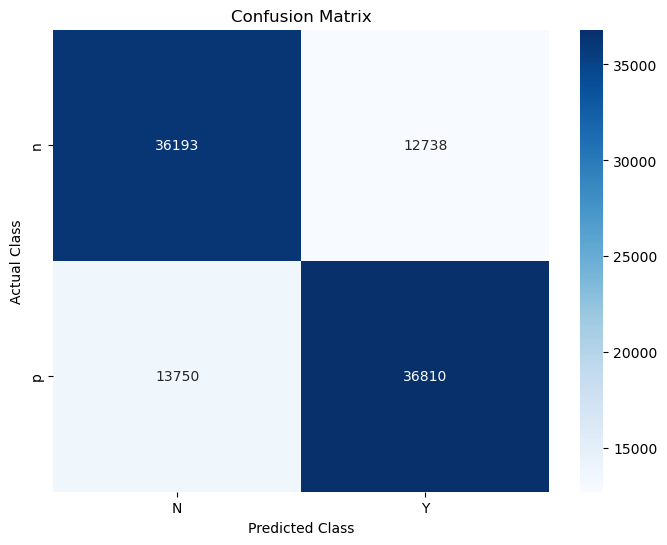

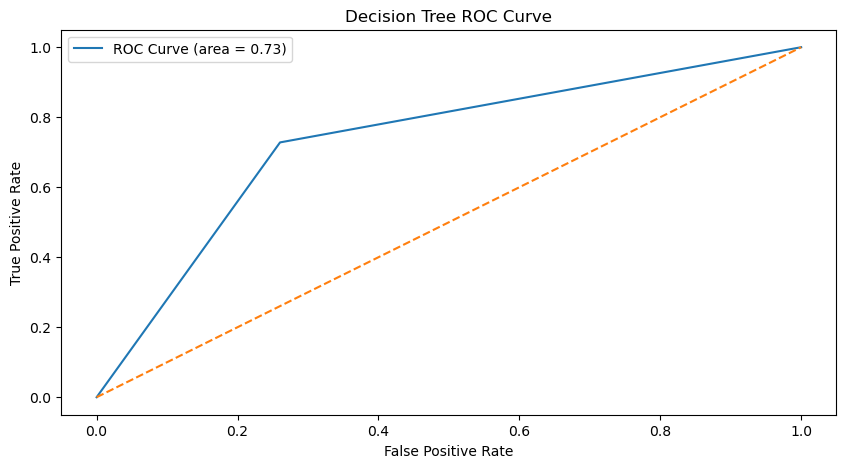

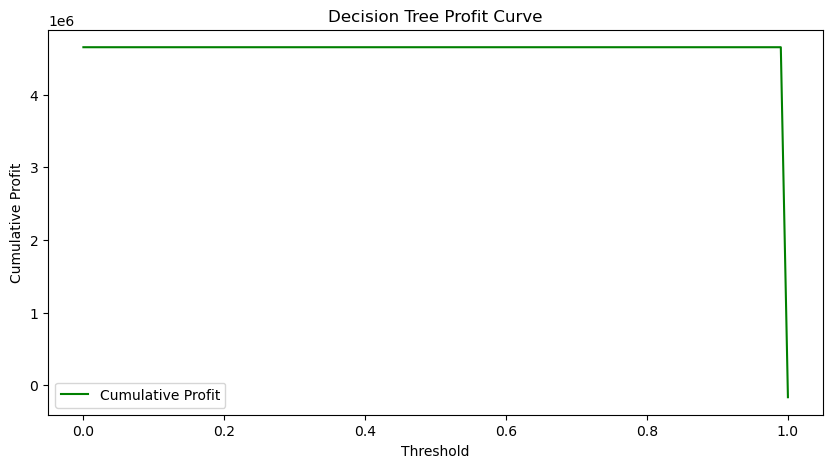

K-Nearest Neighbors - Accuracy: 0.8937


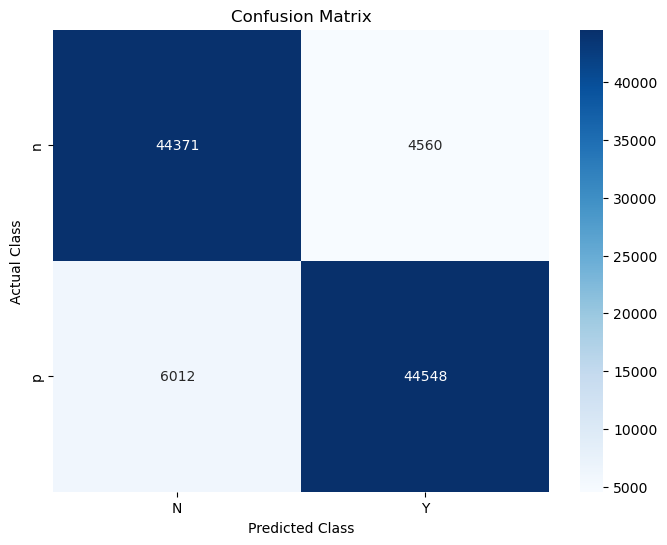

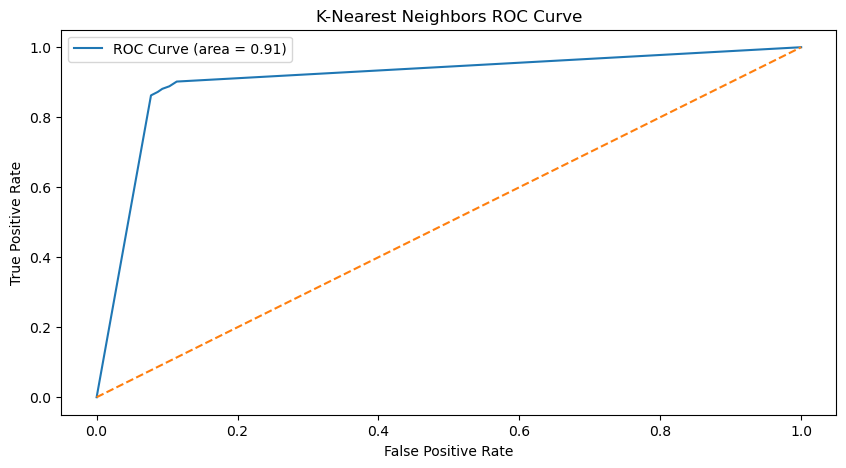

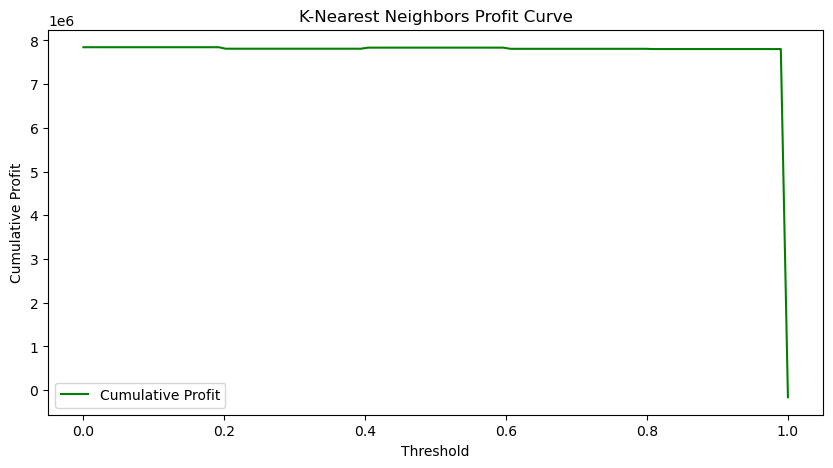

Naive Bayes - Accuracy: 0.5223


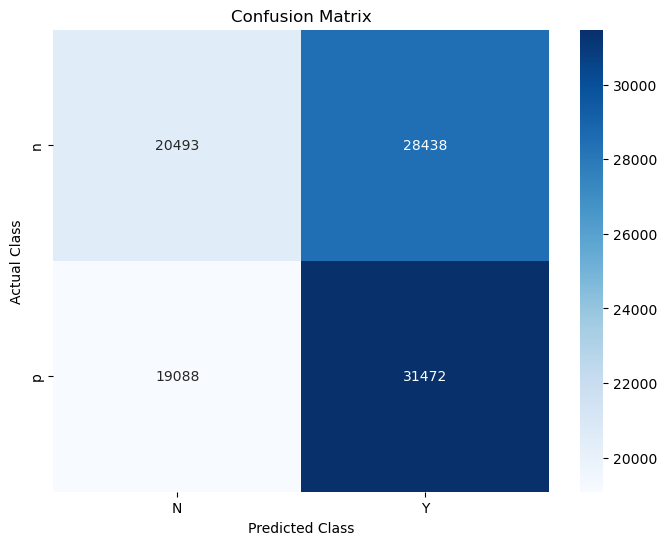

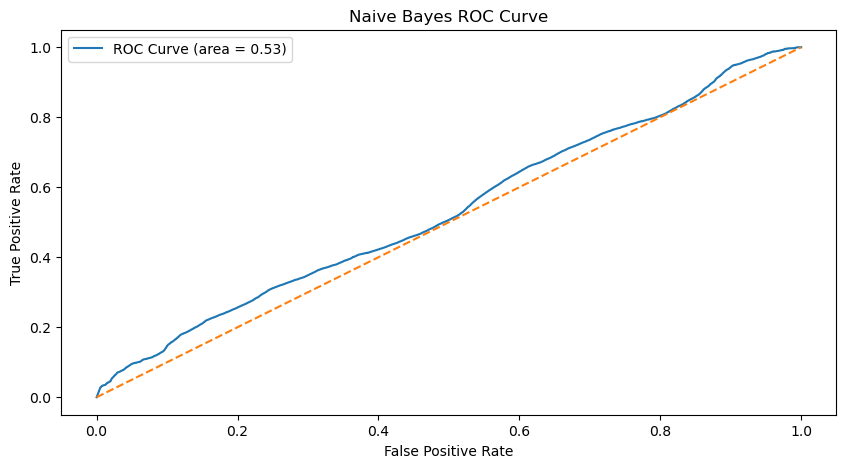

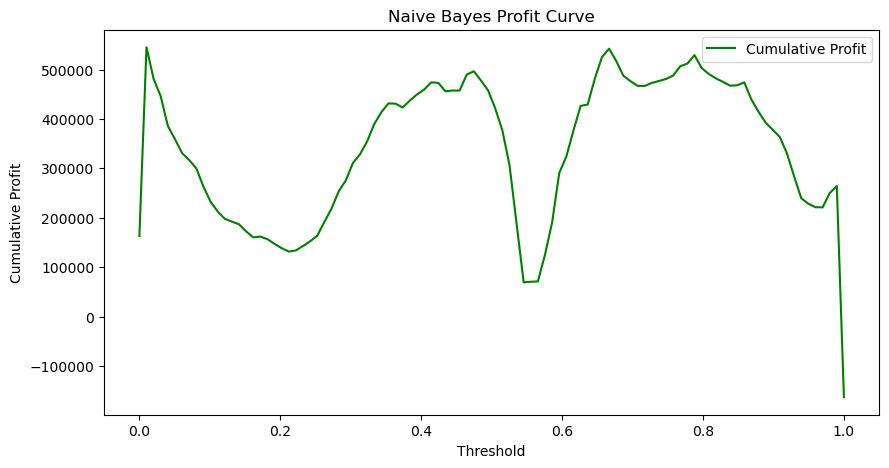

Linear Regression - Accuracy: 0.5205


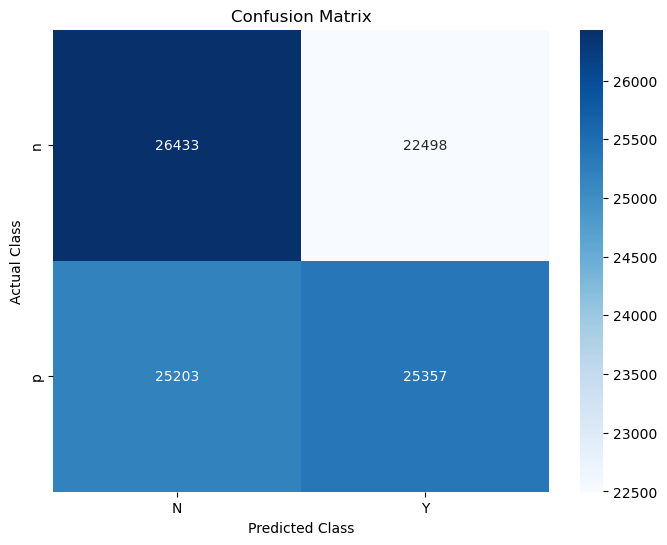

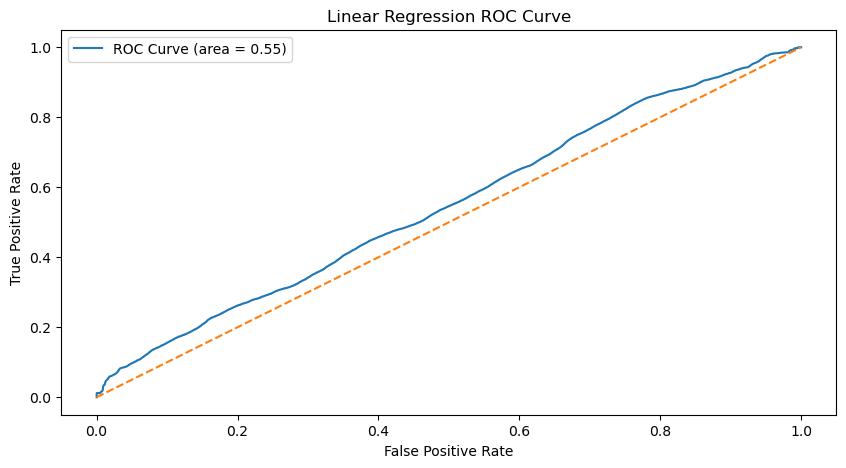

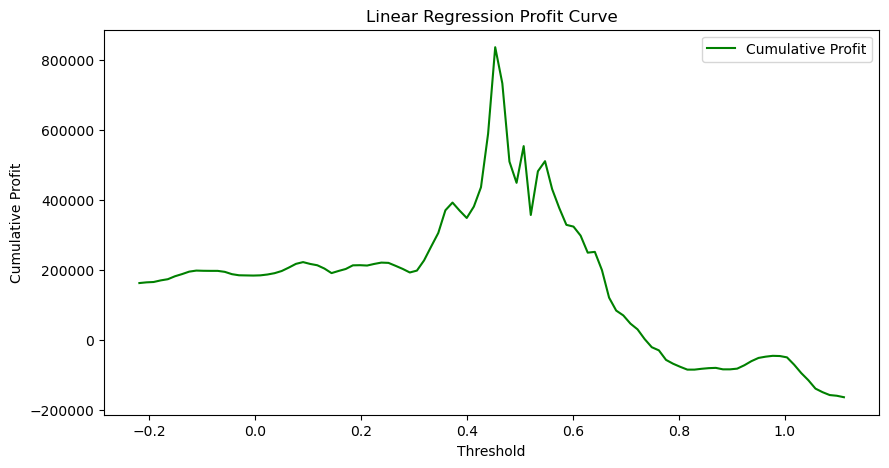

Logistic Regression - Accuracy: 0.5211


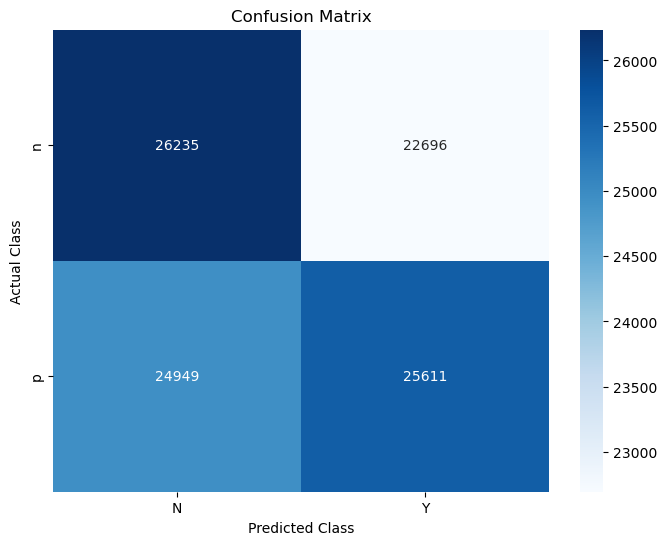

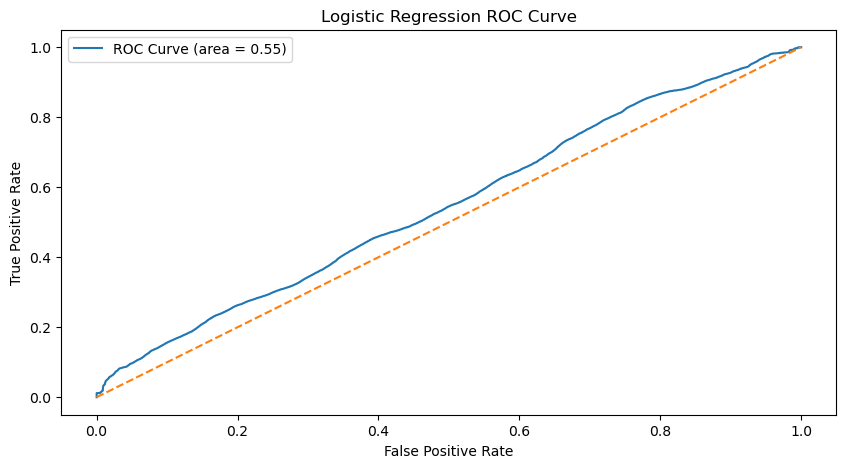

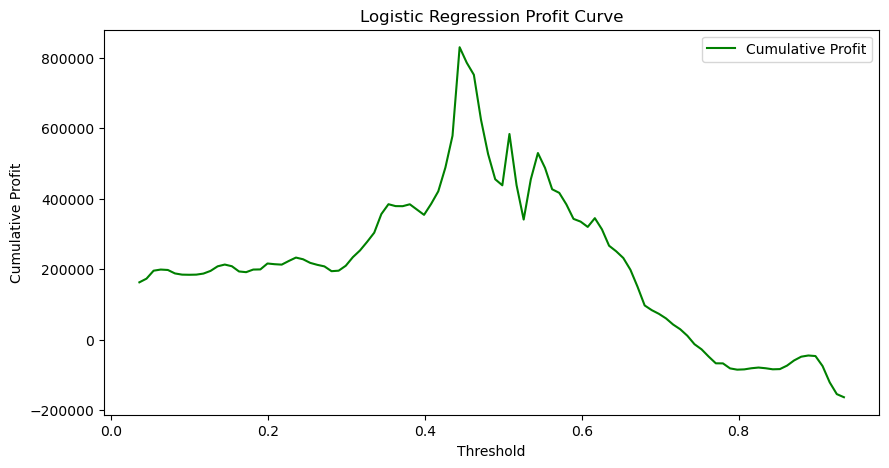

In [12]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, mean_squared_error, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection and Understanding
data_path = 'C:/Users/soham/Documents/Sem_1/IS603/Project/archive/stock_prices.csv'
df = pd.read_csv(data_path)

# Data Preparation
df['close'] = df['close'].values.reshape(-1, 1)
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)
df.dropna(inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['close']])

def create_features(data, targets, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size].flatten())
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_features(scaled_data, df['target'].values, window_size)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression()
}

# Evaluate each classifier
for name, clf in classifiers.items():
    if name == "Linear Regression":
        clf.fit(X_train, y_train)
        y_pred_continuous = clf.predict(X_test)
    else:
        clf.fit(X_train, y_train)
        y_pred_continuous = clf.predict_proba(X_test)[:, 1]

    y_pred_binary = (y_pred_continuous > 0.5).astype(int)

    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred_binary)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    print(f"{name} - Accuracy: {accuracy:.4f}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['n', 'p'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # ROC Curve
    roc_auc = roc_auc_score(y_test, y_pred_continuous)
    fpr, tpr, _ = roc_curve(y_test, y_pred_continuous)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.show()

    # Profit Curve Calculation
    profits = [(100 if (pred > threshold) == actual else -100) for pred, actual in zip(y_pred_continuous, y_test)]
    thresholds = np.linspace(min(y_pred_continuous), max(y_pred_continuous), 100)
    cumulative_profits = []
    for threshold in thresholds:
        decisions = (y_pred_continuous > threshold).astype(int)
        profit = sum(100 if d == actual else -100 for d, actual in zip(decisions, y_test))
        cumulative_profits.append(profit)
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, cumulative_profits, color='green', label='Cumulative Profit')
    plt.xlabel('Threshold')
    plt.ylabel('Cumulative Profit')
    plt.title(f'{name} Profit Curve')
    plt.legend()
    plt.show()